In [ ]:
import os
import xarray as xr
import rioxarray

# Set working directory
os.chdir("C:/Users/konst/Documents/Hiwi/mw3/master_thesis/")

# Load datasets
hlsl = xr.load_dataset("data/satellite_data/eifel/hls_landsat/hls_landsat_2013_2025.nc")
hlss = xr.load_dataset("data/satellite_data/eifel/hls_sentinel/hls_sentinel_2015_2024.nc")
landsat7 = xr.load_dataset("data/satellite_data/eifel/landsat_7_stricter/landsat_7_stricter_2000_2023.nc")

# Add a "satellite" coordinate to each dataset
hlsl = hlsl.assign_coords(satellite="HLS_Landsat")
hlss = hlss.assign_coords(satellite="HLS_Sentinel")
landsat7 = landsat7.assign_coords(satellite="Landsat_7")

# Set the CRS for the hlsl dataset (replace "EPSG:4326" with the correct CRS)
hlss.rio.write_crs("EPSG:4326", inplace=True)
hlsl.rio.write_crs("EPSG:4326", inplace=True)
landsat7.rio.write_crs("EPSG:4326", inplace=True)

# Open the landcover raster with rioxarray
landcover = rioxarray.open_rasterio("data/satellite_data/eifel/landcover/ESA_WorldCover_10m_2021_v200_N48E006_Map.tif")

# Reproject the mask to match the NetCDF data's CRS and resolution
mask_reprojected = landcover.sel(band=1).rio.reproject_match(hlsl)

# Create a boolean mask where the landcover class is 10
mask_xr = mask_reprojected == 10

# Apply the mask to each dataset
hlsl = hlsl.where(mask_xr)
hlss = hlss.where(mask_xr)
landsat7 = landsat7.where(mask_xr)

# Exclude specific dates (keep them as strings)
hlss_exclude = ["2016-01-19", "2016-02-18", "2016-11-24", "2017-02-02", "2018-02-27"]
hlsl_exclude = ["2016-01-19", "2017-01-21", "2024-01-09", "2024-01-18"]
landsat7_exclude = [
    "2000-01-24", "2000-04-13", "2001-03-06", "2001-11-10", "2002-01-04", 
    "2002-01-13", "2002-02-12", "2002-04-10", "2002-06-29", "2003-02-01", 
    "2003-02-17", "2003-02-24", "2003-05-31", "2004-11-09", "2004-12-04", 
    "2005-03-10", "2006-03-13", "2009-04-13", "2011-03-27", "2012-02-10", 
    "2013-11-27", "2014-01-05", "2014-11-14", "2017-01-06", "2017-01-22", 
    "2017-06-25", "2017-12-08", "2018-03-30", "2018-04-15", "2018-07-04", 
    "2019-01-19", "2019-02-04", "2021-02-09", "2021-06-26", "2021-08-13", 
    "2022-03-16", "2022-11-02", "2024-03-01"
]

# Apply filtering using strings
hlss = hlss.sel(time=~hlss.time.isin(hlss_exclude))
hlsl = hlsl.sel(time=~hlsl.time.isin(hlsl_exclude))
landsat7 = landsat7.sel(time=~landsat7.time.isin(landsat7_exclude))

# Extract time values and convert to sets
hlsl_dates = set(hlsl.time.values)
hlss_dates = set(hlss.time.values)
landsat7_dates = set(landsat7.time.values)

# Find common dates between each pair
common_hlsl_hlss = hlsl_dates.intersection(hlss_dates)
common_hlsl_landsat7 = hlsl_dates.intersection(landsat7_dates)
common_hlss_landsat7 = hlss_dates.intersection(landsat7_dates)
common_hlsl_hlss = sorted(str(date) for date in common_hlsl_hlss)
common_hlsl_landsat7 = sorted(str(date) for date in common_hlsl_landsat7)
common_hlss_landsat7 = sorted(str(date) for date in common_hlss_landsat7)

# Print the results
print(f"Common dates between HLS-Landsat and HLS-Sentinel: {sorted(common_hlsl_hlss)}")
print(f"Common dates between HLS-Landsat and Landsat-7: {sorted(common_hlsl_landsat7)}")
print(f"Common dates between HLS-Sentinel and Landsat-7: {sorted(common_hlss_landsat7)}")

Common dates between HLS-Landsat and HLS-Sentinel: ['2016-12-04', '2017-10-20', '2021-04-22', '2023-05-22', '2023-06-16', '2023-09-04', '2024-04-06', '2024-05-01', '2024-06-25']
Common dates between HLS-Landsat and Landsat-7: ['2022-02-28', '2022-03-09', '2022-03-25', '2022-05-11', '2022-07-23', '2023-06-24']
Common dates between HLS-Sentinel and Landsat-7: ['2016-08-06', '2017-04-03', '2017-06-22', '2017-09-10', '2017-11-29', '2020-04-27', '2023-07-11', '2023-07-16']


Comparing HLS-Landsat vs. HLS-Sentinel:
  - Number of common dates: 9


C:\Users\konst\AppData\Local\Temp\ipykernel_27912\2935632460.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x_vals_total, y_vals_total, c=colors, s=5, alpha=0.7,


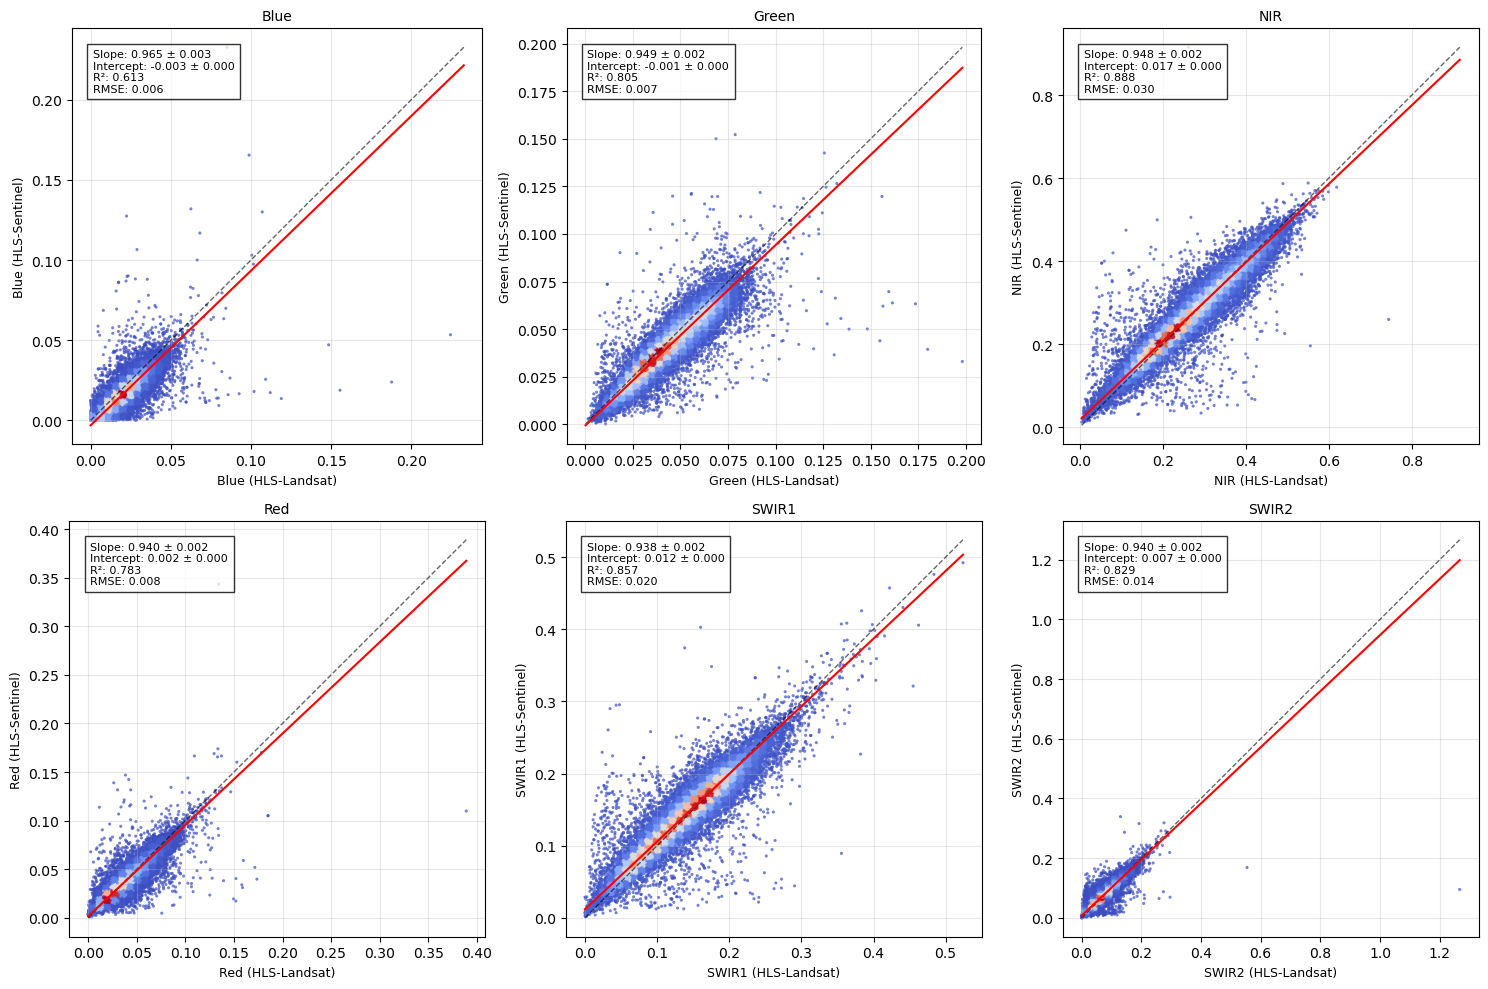

Comparing HLS-Landsat vs. Landsat-7:
  - Number of common dates: 6


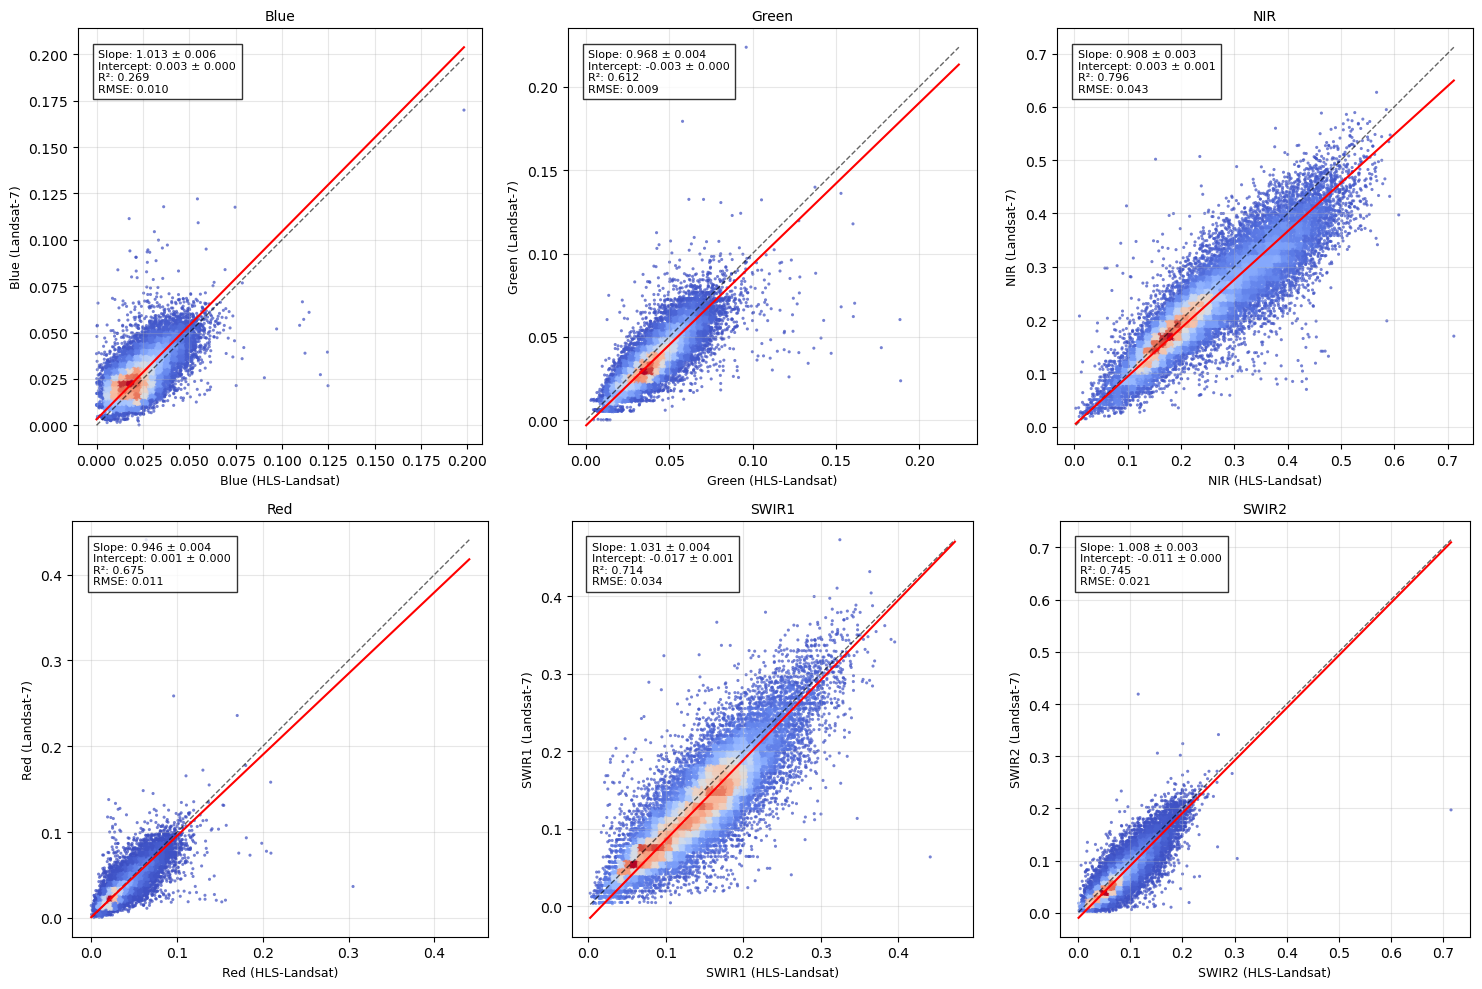

Comparing HLS-Sentinel vs. Landsat-7:
  - Number of common dates: 8


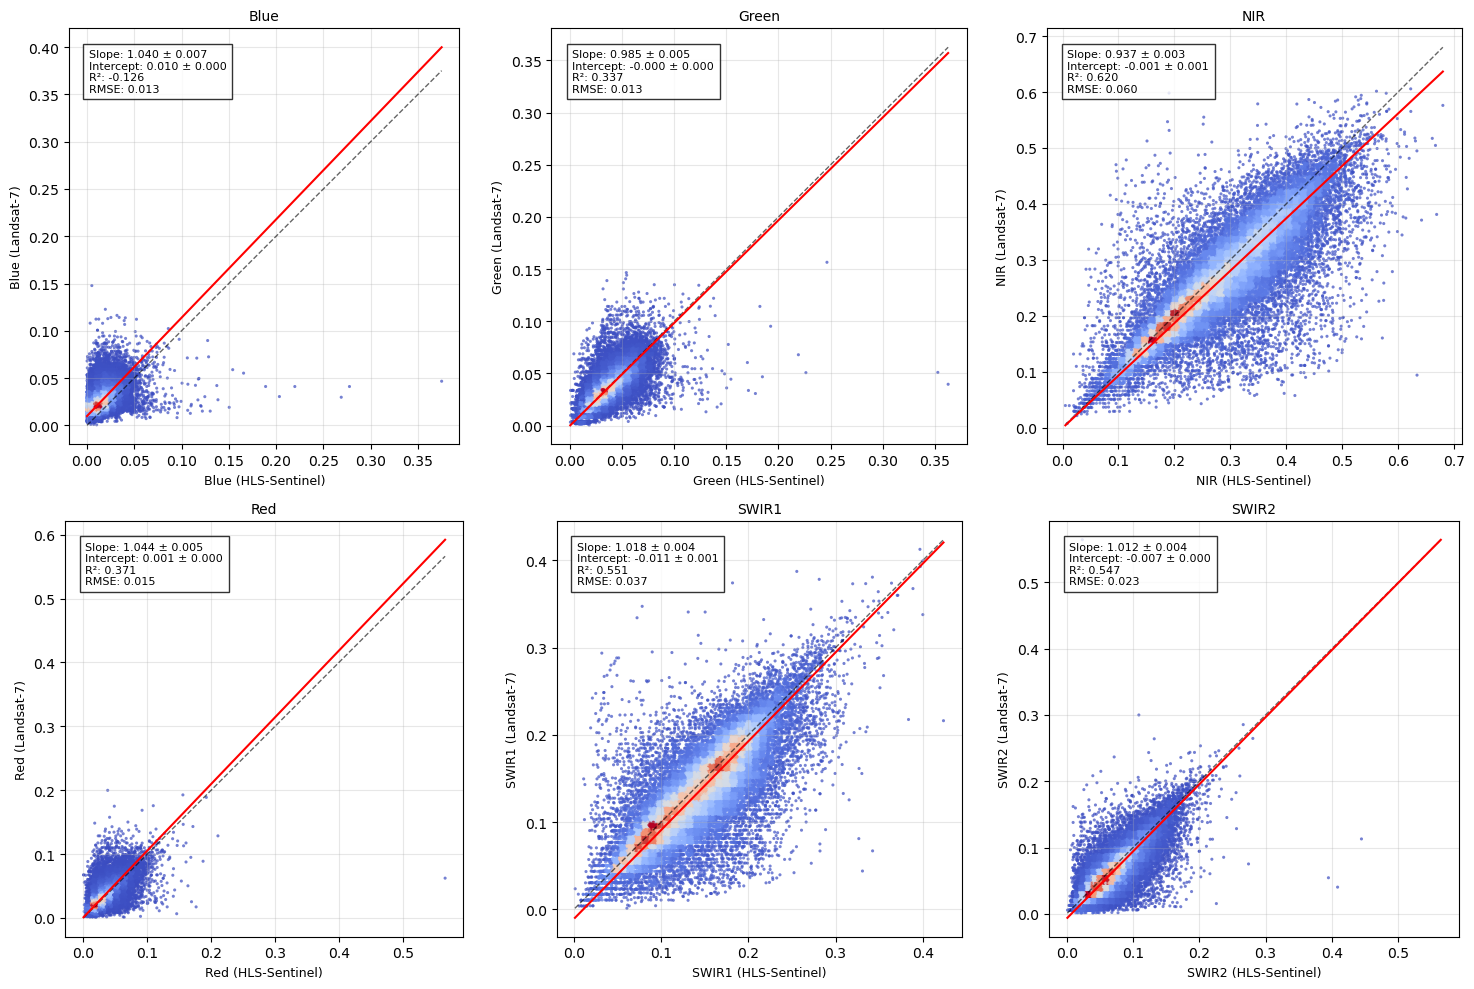

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData  # Added for ODR
import matplotlib.cm as cm
coolwarm = cm.coolwarm  # Assign the colormap

# -------------------------------------------------------------------------- #
# Function to create scatter plots for a pair of datasets
# -------------------------------------------------------------------------- #
def create_scatter_plots(
    ds_x, ds_y, common_dates, ds_x_name, ds_y_name, 
    band_names=None, num_pixels=4000
):
    print(f"Comparing {ds_x_name} vs. {ds_y_name}:")
    print(f"  - Number of common dates: {len(common_dates)}")

    if band_names is None:
        band_names = list(set(ds_x.data_vars.keys()) & set(ds_y.data_vars.keys()))
        band_names = sorted(band_names)
    actual_bands = [b for b in band_names if b in ds_x.data_vars and b in ds_y.data_vars]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    axes = axes.flatten()

    for idx, band in enumerate(actual_bands[:6]):
        ax = axes[idx]
        x_vals_total, y_vals_total = [], []

        for date in common_dates:
            arr_x = ds_x[band].sel(time=date).values.ravel()
            arr_y = ds_y[band].sel(time=date).values.ravel()
            valid_mask = ~np.isnan(arr_x) & ~np.isnan(arr_y)
            arr_x, arr_y = arr_x[valid_mask], arr_y[valid_mask]
            
            if len(arr_x) >= num_pixels:
                rand_idx = np.random.choice(len(arr_x), size=num_pixels, replace=False)
                x_vals_total.append(arr_x[rand_idx])
                y_vals_total.append(arr_y[rand_idx])

        if not x_vals_total:
            ax.set_title(f"{band}\nNo valid samples")
            ax.grid(True, alpha=0.3)
            continue

        x_vals_total = np.concatenate(x_vals_total)
        y_vals_total = np.concatenate(y_vals_total)

        hist, x_edges, y_edges = np.histogram2d(
            x_vals_total, y_vals_total, bins=50, 
            range=[[x_vals_total.min(), x_vals_total.max()], 
                   [y_vals_total.min(), y_vals_total.max()]]
        )
        x_bins = np.clip(np.digitize(x_vals_total, x_edges) - 1, 0, hist.shape[0]-1)
        y_bins = np.clip(np.digitize(y_vals_total, y_edges) - 1, 0, hist.shape[1]-1)
        density = hist[x_bins, y_bins]
        colors = coolwarm(density / density.max())

        def linear_model(beta, x):
            return beta[0] * x + beta[1]
        
        odr_model = Model(linear_model)
        data = RealData(x_vals_total, y_vals_total, 
                       sx=np.std(x_vals_total), 
                       sy=np.std(y_vals_total))
        odr = ODR(data, odr_model, beta0=[1.0, 0.0])
        odr_result = odr.run()
        slope, intercept = odr_result.beta
        sa, sb = odr_result.sd_beta

        # --- Calculate R² (using the ODR model) ---
        y_pred = slope * x_vals_total + intercept
        ss_res = np.sum((y_vals_total - y_pred) ** 2)
        ss_tot = np.sum((y_vals_total - np.mean(y_vals_total)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # --- Calculate RMSE ---
        rmse = np.sqrt(np.mean((y_vals_total - y_pred) ** 2))

        # --- Plotting ---
        ax.scatter(x_vals_total, y_vals_total, c=colors, s=5, alpha=0.7, 
                  edgecolors='none', cmap='coolwarm')
        lim_min = min(x_vals_total.min(), y_vals_total.min())
        lim_max = max(x_vals_total.max(), y_vals_total.max())
        ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', alpha=0.6, lw=1)
        
        x_fit = np.linspace(lim_min, lim_max, 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r-', lw=1.5, label='ODR Fit')

        # --- Annotation Box ---
        textstr = '\n'.join((
            f'Slope: {slope:.3f} ± {sa:.3f}',
            f'Intercept: {intercept:.3f} ± {sb:.3f}',
            f'R²: {r_squared:.3f}',
            f'RMSE: {rmse:.3f}'
        ))
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        ax.set_title(f"{band}", fontsize=10)
        ax.set_xlabel(f"{band} ({ds_x_name})", fontsize=9)
        ax.set_ylabel(f"{band} ({ds_y_name})", fontsize=9)
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)

    for j in range(len(actual_bands), 6):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# 1) HLS-Landsat vs. HLS-Sentinel
create_scatter_plots(
    ds_x=hlsl,
    ds_y=hlss,
    common_dates=common_hlsl_hlss,
    ds_x_name="HLS-Landsat",
    ds_y_name="HLS-Sentinel"
)

# 2) HLS-Landsat vs. Landsat7
create_scatter_plots(
    ds_x=hlsl,
    ds_y=landsat7,
    common_dates=common_hlsl_landsat7,
    ds_x_name="HLS-Landsat",
    ds_y_name="Landsat-7"
)

# 3) HLS-Sentinel vs. Landsat7
create_scatter_plots(
    ds_x=hlss,
    ds_y=landsat7,
    common_dates=common_hlss_landsat7,
    ds_x_name="HLS-Sentinel",
    ds_y_name="Landsat-7"
)


Comparing HLS-Landsat vs. HLS-Sentinel:
  - Number of common dates: 9


C:\Users\konst\AppData\Local\Temp\ipykernel_27912\647749778.py:127: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x_vals_total, y_vals_total, c=colors, s=5, alpha=0.7,


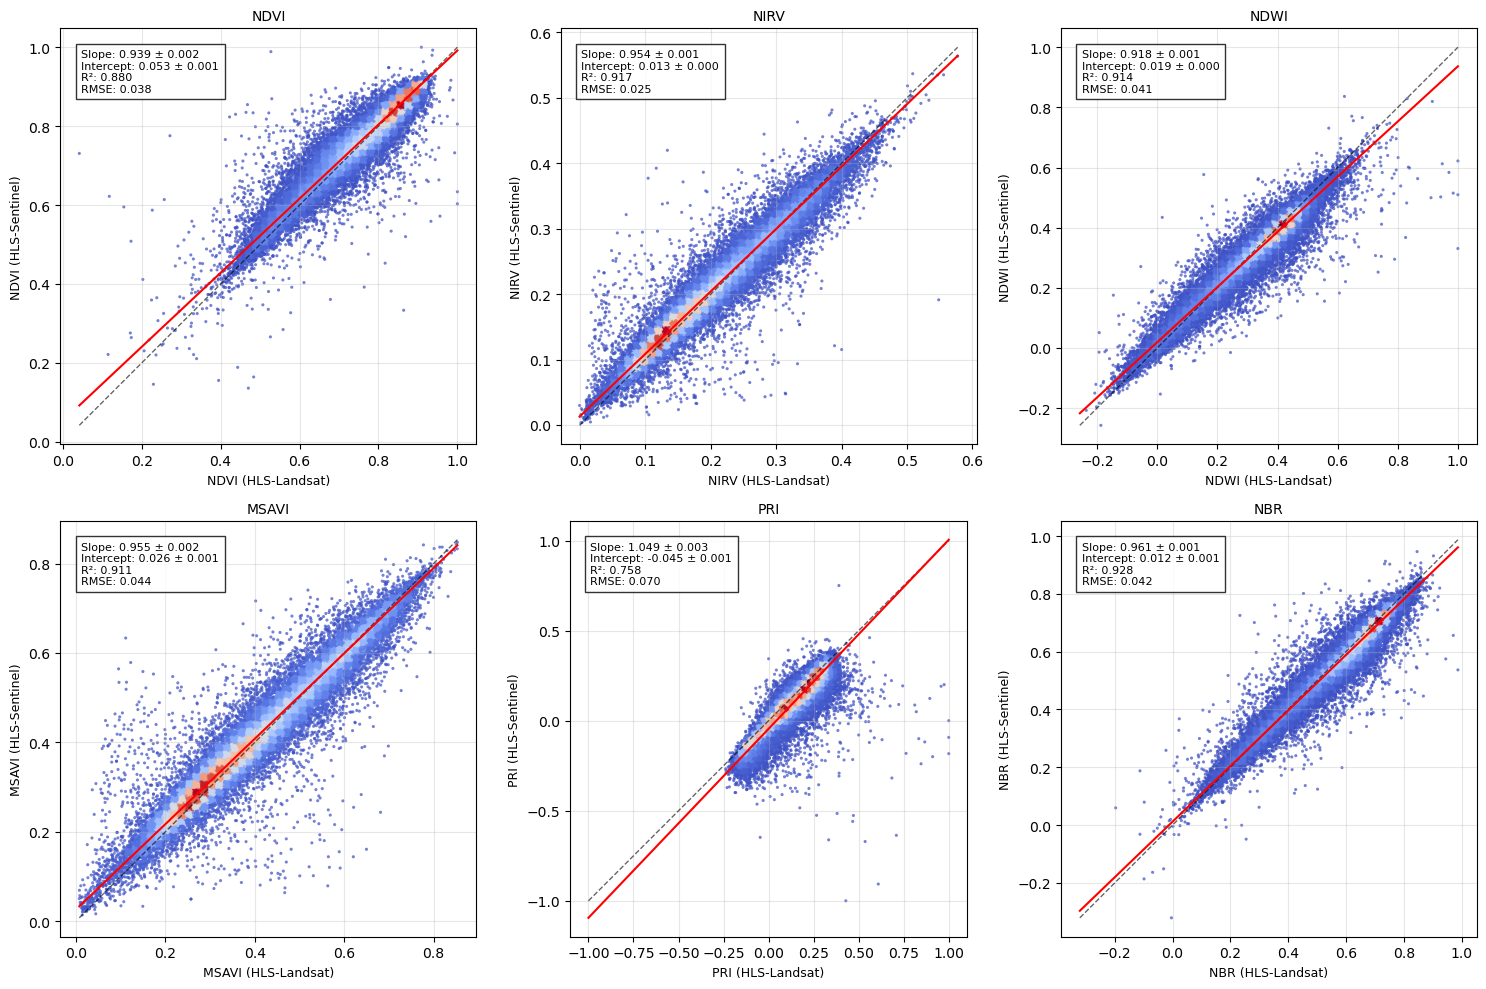

Comparing HLS-Landsat vs. Landsat-7:
  - Number of common dates: 6


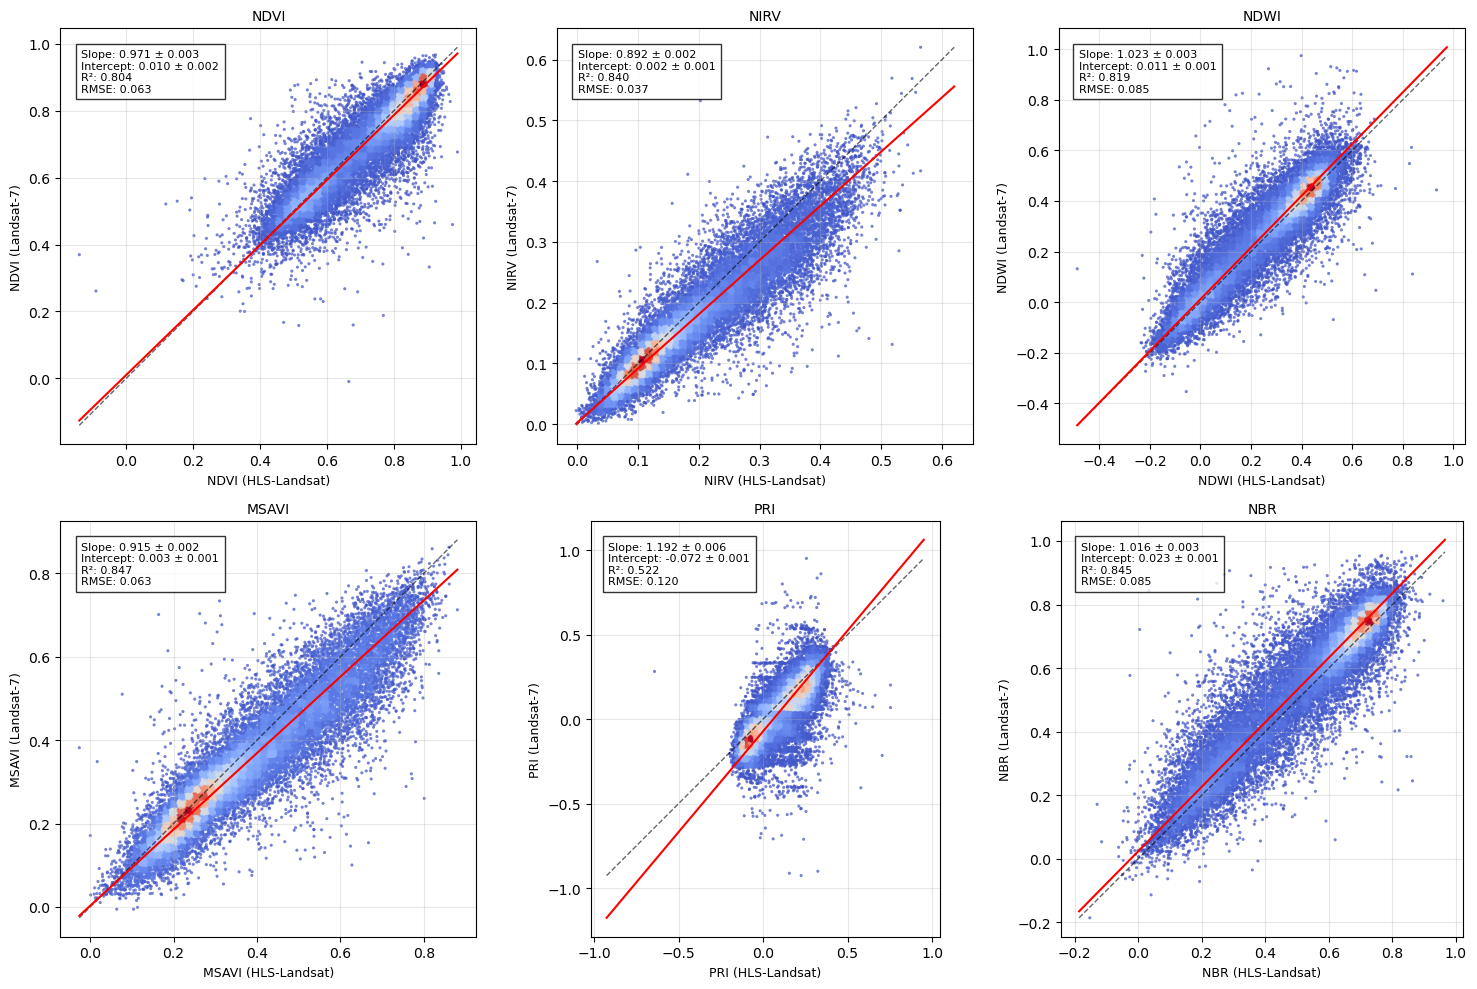

Comparing HLS-Sentinel vs. Landsat-7:
  - Number of common dates: 8


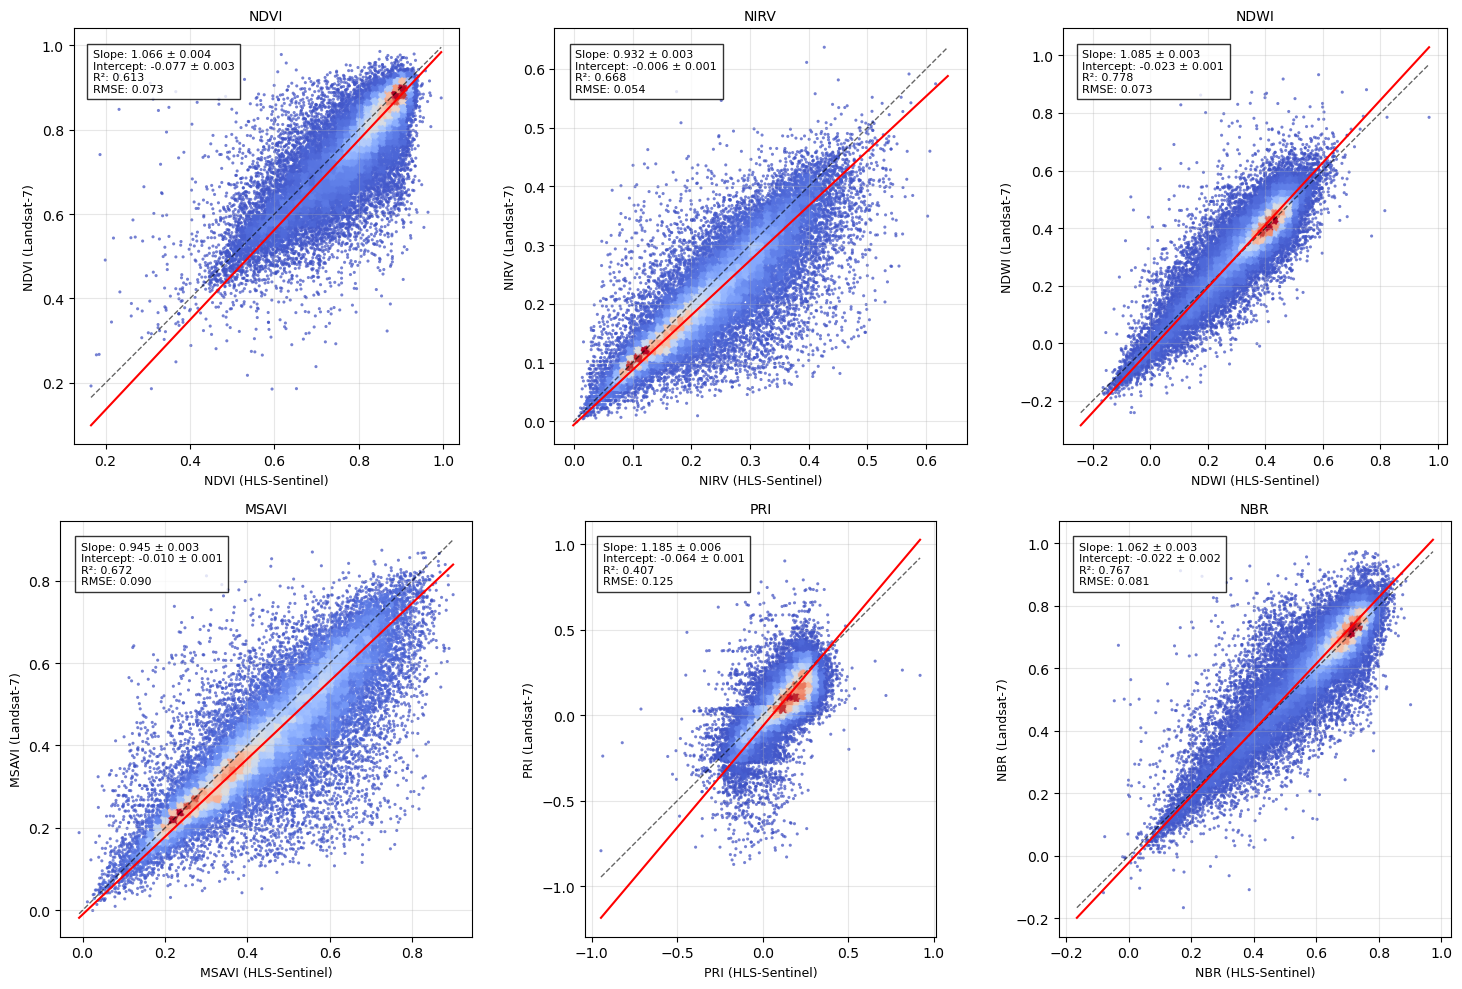

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
import matplotlib.cm as cm  # For heatmap colors

# -------------------------------------------------------------------------- #
# Compute Vegetation Indices for a dataset
# -------------------------------------------------------------------------- #
def compute_veg_indices(ds):
    """
    Given an xarray.Dataset with bands, compute common vegetation indices.
    Returns a copy of the dataset with new data variables:
      - NDVI: (NIR - Red) / (NIR + Red)
      - NIRV: NDVI * NIR
      - NDWI: (NIR - SWIR1) / (NIR + SWIR1)
      - MSAVI: (2*NIR + 1 - sqrt((2*NIR + 1)**2 - 8*(NIR - Red)))/2
      - PRI: (Green - Red) / (Green + Red)
      - NBR: (NIR - SWIR2) / (NIR + SWIR2)
    """
    ds = ds.copy()  # work on a copy so the original dataset remains unchanged

    ds['NDVI']  = (ds['NIR']  - ds['Red'])   / (ds['NIR']  + ds['Red'])
    ds['NIRV']  = ds['NDVI'] * ds['NIR']
    ds['NDWI']  = (ds['NIR']  - ds['SWIR1']) / (ds['NIR']  + ds['SWIR1'])
    ds['MSAVI'] = (2 * ds['NIR'] + 1 - np.sqrt((2 * ds['NIR'] + 1)**2 - 8 * (ds['NIR'] - ds['Red']))) / 2
    ds['PRI']   = (ds['Green'] - ds['Red'])  / (ds['Green'] + ds['Red'])
    ds['NBR']   = (ds['NIR']  - ds['SWIR2']) / (ds['NIR']  + ds['SWIR2'])

    return ds

# -------------------------------------------------------------------------- #
# Function to create scatter plots for a pair of datasets using Vegetation Indices
# -------------------------------------------------------------------------- #
def create_scatter_plots_indices(
    ds_x, ds_y, common_dates, ds_x_name, ds_y_name, 
    indices_list=None, num_pixels=4000
):
    print(f"Comparing {ds_x_name} vs. {ds_y_name}:")
    print(f"  - Number of common dates: {len(common_dates)}")

    # Compute vegetation indices on both datasets.
    ds_x = compute_veg_indices(ds_x)
    ds_y = compute_veg_indices(ds_y)

    # Default indices to plot if none are provided.
    if indices_list is None:
        indices_list = ['NDVI', 'NIRV', 'NDWI', 'MSAVI', 'PRI', 'NBR']
    # Use only indices that exist in both datasets.
    actual_indices = [idx for idx in indices_list if idx in ds_x.data_vars and idx in ds_y.data_vars]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    axes = axes.flatten()

    for idx, index in enumerate(actual_indices[:6]):
        ax = axes[idx]
        x_vals_total, y_vals_total = [], []

        for date in common_dates:
            # Retrieve the index arrays for each date.
            arr_x = ds_x[index].sel(time=date).values.ravel()
            arr_y = ds_y[index].sel(time=date).values.ravel()
            valid_mask = ~np.isnan(arr_x) & ~np.isnan(arr_y)
            arr_x, arr_y = arr_x[valid_mask], arr_y[valid_mask]
            
            if len(arr_x) >= num_pixels:
                rand_idx = np.random.choice(len(arr_x), size=num_pixels, replace=False)
                x_vals_total.append(arr_x[rand_idx])
                y_vals_total.append(arr_y[rand_idx])

        if not x_vals_total:
            ax.set_title(f"{index}\nNo valid samples")
            ax.grid(True, alpha=0.3)
            continue

        x_vals_total = np.concatenate(x_vals_total)
        y_vals_total = np.concatenate(y_vals_total)

        # --- Create Heatmap Colors via Density ---
        hist, x_edges, y_edges = np.histogram2d(
            x_vals_total, y_vals_total, bins=50, 
            range=[[x_vals_total.min(), x_vals_total.max()], 
                   [y_vals_total.min(), y_vals_total.max()]]
        )
        x_bins = np.clip(np.digitize(x_vals_total, x_edges) - 1, 0, hist.shape[0]-1)
        y_bins = np.clip(np.digitize(y_vals_total, y_edges) - 1, 0, hist.shape[1]-1)
        density = hist[x_bins, y_bins]
        colors = cm.coolwarm(density / density.max())  # Using coolwarm from matplotlib.cm

        # --- Define the Linear Model for ODR ---
        def linear_model(beta, x):
            return beta[0] * x + beta[1]
        
        odr_model = Model(linear_model)
        std_x = np.std(x_vals_total)
        std_y = np.std(y_vals_total)
        
        # Check for zero variance (or nearly zero) to avoid division errors.
        if std_x == 0 or std_y == 0:
            print(f"Skipping {index} due to zero variance.")
            ax.set_title(f"{index}\nZero variance")
            ax.grid(True, alpha=0.3)
            continue

        data = RealData(x_vals_total, y_vals_total, sx=std_x, sy=std_y)
        odr = ODR(data, odr_model, beta0=[1.0, 0.0])
        
        try:
            odr_result = odr.run()
        except RuntimeError:
            print(f"ODR failed for {index}. Skipping...")
            ax.set_title(f"{index}\nODR failed")
            ax.grid(True, alpha=0.3)
            continue

        slope, intercept = odr_result.beta
        sa, sb = odr_result.sd_beta

        # --- Calculate ODR-based R² and RMSE ---
        y_pred = slope * x_vals_total + intercept
        ss_res = np.sum((y_vals_total - y_pred) ** 2)
        ss_tot = np.sum((y_vals_total - np.mean(y_vals_total)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
        rmse = np.sqrt(np.mean((y_vals_total - y_pred) ** 2))

        # --- Plotting ---
        ax.scatter(x_vals_total, y_vals_total, c=colors, s=5, alpha=0.7,
                   edgecolors='none', cmap='coolwarm')
        lim_min = min(x_vals_total.min(), y_vals_total.min())
        lim_max = max(x_vals_total.max(), y_vals_total.max())
        ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', alpha=0.6, lw=1)
        
        x_fit = np.linspace(lim_min, lim_max, 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r-', lw=1.5, label='ODR Fit')

        # --- Annotation ---
        textstr = '\n'.join((
            f'Slope: {slope:.3f} ± {sa:.3f}',
            f'Intercept: {intercept:.3f} ± {sb:.3f}',
            f'R²: {r_squared:.3f}',
            f'RMSE: {rmse:.3f}'
        ))
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        ax.set_title(f"{index}", fontsize=10)
        ax.set_xlabel(f"{index} ({ds_x_name})", fontsize=9)
        ax.set_ylabel(f"{index} ({ds_y_name})", fontsize=9)
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)

    # Hide unused subplots if any.
    for j in range(len(actual_indices), 6):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# 1) HLS-Landsat vs. HLS-Sentinel
create_scatter_plots_indices(
    ds_x=hlsl,
    ds_y=hlss,
    common_dates=common_hlsl_hlss,
    ds_x_name="HLS-Landsat",
    ds_y_name="HLS-Sentinel"
)

# 2) HLS-Landsat vs. Landsat7
create_scatter_plots_indices(
    ds_x=hlsl,
    ds_y=landsat7,
    common_dates=common_hlsl_landsat7,
    ds_x_name="HLS-Landsat",
    ds_y_name="Landsat-7"
)

# 3) HLS-Sentinel vs. Landsat7
create_scatter_plots_indices(
    ds_x=hlss,
    ds_y=landsat7,
    common_dates=common_hlss_landsat7,
    ds_x_name="HLS-Sentinel",
    ds_y_name="Landsat-7"
)

In [28]:
def get_rgb_image(ds, date, clip=(2, 98)):
    # Select data for that exact date
    ds_sel = ds.sel(time=date)  # no "nearest" here
    # Extract red, green, blue as numpy arrays
    r, g, b = [ds_sel[band].values for band in ["Red", "Green", "Blue"]]
    
    # Replace NaNs with 0
    r = np.nan_to_num(r, nan=0)
    g = np.nan_to_num(g, nan=0)
    b = np.nan_to_num(b, nan=0)
    
    # Stack bands into RGB array
    rgb = np.dstack([r, g, b])
    
    # Percentile-based contrast stretching
    low, high = np.percentile(rgb, clip)
    print("Percentile low/high:", low, high)  # Debug print
    if high == low:  # Avoid division by zero
        high = low + 1e-10
    rgb_scaled = (rgb - low) / (high - low)
    rgb_scaled = np.clip(rgb_scaled, 0, 1)  # Ensure values are in [0, 1]
    
    return rgb_scaled

# 4) Function to plot two RGB images side by side and save
def plot_two_rgb_images(date, ds1, ds2, name1, name2, out_dir="figures"):
    os.makedirs(out_dir, exist_ok=True)
    rgb1 = get_rgb_image(ds1, date)
    rgb2 = get_rgb_image(ds2, date)
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(rgb1); axs[0].axis("off"); axs[0].set_title(f"{name1}\n{date}")
    axs[1].imshow(rgb2); axs[1].axis("off"); axs[1].set_title(f"{name2}\n{date}")
    plt.tight_layout()
    fname = f"{name1}_vs_{name2}_{date}.png".replace(" ", "_")
    plt.savefig(os.path.join(out_dir, fname), dpi=150, bbox_inches="tight")
    plt.close(fig)

# 5) Loop through each pair’s common dates and plot
for date in common_hlsl_hlss:
    plot_two_rgb_images(date, hlsl, hlss, "HLS-Landsat", "HLS-Sentinel")

for date in common_hlsl_landsat7:
    plot_two_rgb_images(date, hlsl, landsat7, "HLS-Landsat", "Landsat-7")

for date in common_hlss_landsat7:
    plot_two_rgb_images(date, hlss, landsat7, "HLS-Sentinel", "Landsat-7")

print("All side-by-side plots saved in the 'figures/' folder.")

Percentile low/high: 0.0 0.049300000071525574
Percentile low/high: 0.0 0.05180000141263008
Percentile low/high: 0.0 0.05119999870657921
Percentile low/high: 0.0 0.050700001418590546
Percentile low/high: 0.0 0.07320000231266022
Percentile low/high: 0.0 0.07320000231266022
Percentile low/high: 0.0 0.07180000096559525
Percentile low/high: 0.0 0.06459999829530716
Percentile low/high: 0.0 0.06589999794960022
Percentile low/high: 0.0 0.061799999326467514
Percentile low/high: 0.0 0.05169999971985817
Percentile low/high: 0.0 0.05169999971985817
Percentile low/high: 0.0 0.05829999968409538
Percentile low/high: 0.0 0.0632999986410141
Percentile low/high: 0.0 0.07129999995231628
Percentile low/high: 0.0 0.06440000236034393
Percentile low/high: 0.0 0.05810000002384186
Percentile low/high: 0.0 0.05689999833703041
Percentile low/high: 0.0 0.06759999692440033
Percentile low/high: 0.0 0.05899500101804733
Percentile low/high: 0.0 0.0731000006198883
Percentile low/high: 0.0 0.0652649998664856
Percentile

In [5]:
mask

False